In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, poisson
import numpy as np
import math

df = pd.read_csv('output.csv')
## Data Cleaning : 
df['Value'] = df['Value'].str.rstrip(' ETH')
df['Value'] = df['Value'].apply(lambda x: float(x.rstrip(' wei')) *10**-18 if x.endswith('wei') else (x))

df['Value'] = df['Value'].astype(float)
df['Value'] = df['Value'].replace(0.0, 10**-18)
df['Value'] = df['Value'].replace(0, 10**-18)

df['Txn Fee'] = df['Txn Fee'].astype(float)

df = df.drop_duplicates(subset='Hash', keep='first')
df.to_csv('output_cleaned_epsilon.csv', index=False)

We've already extracted the data from the website, but it still needs to be cleaned up. Firstly, we need to eliminate any extraneous information, such as 'ETH' from the 'value' column. Additionally, due to dynamic data loading, we must remove any duplicate rows. Once this is accomplished, we'll be good to go!

Value - Mean: 0.4429613353563692, Standard Deviation: 5.118537271456196
Txn Fee - Mean: 0.006326284373388345, Standard Deviation: 0.03817592629810732


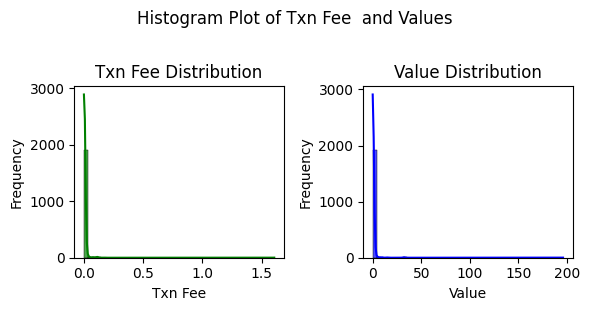

In [4]:
mean_value = df['Value'].mean()
std_value = df['Value'].std()

df['Value'].to_csv("value.csv")
df['Txn Fee'].to_csv("TxnFee.csv")
mean_txn_fee = df['Txn Fee'].mean()
std_txn_fee = df['Txn Fee'].std()

print(f"Value - Mean: {mean_value}, Standard Deviation: {std_value}")
print(f"Txn Fee - Mean: {mean_txn_fee}, Standard Deviation: {std_txn_fee}")


# num_bins_sturges = int(1 + math.log2(len(df['Value'])))


plt.figure(figsize=(6, 3))
plt.suptitle('Histogram Plot of Txn Fee  and Values', y=1.02) 

plt.subplot(1, 2, 1)
sns.histplot(df['Txn Fee'], bins=int(math.sqrt(len(df['Txn Fee']))), color='g', kde=True, alpha=0.7)
plt.title('Txn Fee Distribution')
plt.xlabel('Txn Fee')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(df['Value'], bins=int(math.sqrt(len(df['Value']))), color='b', kde=True, alpha=0.7)
plt.title('Value Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

When dealing with a small set of data (less than 30 points), it's better to use a simpler approach for determining the bin size in a histogram. Instead of using the Sturges formula, which may not work well with such a small dataset, we opted for the square root rule. This choice helps in creating a histogram that effectively represents the continuity of the data, especially considering the limited number of data points and the relatively low values in our dataset.

The standard deviation was found to be higher than the mean, indicating a notable degree of variability within our dataset. This suggests that our data points are quite spread out from the average.


To delve deeper into our investigation, we employ the computation of skewness and kurtosis. Skewness is determined through the third central moment, while kurtosis is assessed using the fourth central moment.

In [5]:
from scipy.stats import skew, kurtosis

skewness_value = skew(df['Value'])
kurtosis_value = kurtosis(df['Value'])

print(f"Value Skewness: {skewness_value}")
print(f"Value Kurtosis: {kurtosis_value}")

skewness_value = skew(df['Txn Fee'])
kurtosis_value = kurtosis(df['Txn Fee'])

print(f"Txn FeeSkewness  : {skewness_value}")
print(f"Txn Fee Kurtosis: {kurtosis_value}")

Value Skewness: 30.954918843476335
Value Kurtosis: 1121.6957076096298
Txn FeeSkewness  : 38.30979714639741
Txn Fee Kurtosis: 1596.0740620151823


The skewness, representing the 3rd central moment, positive indicates a right-skewed distribution characterized by a moderate tail on the right side. Concurrently, the negative kurtosis, denoting the 4th central moment, implies a distribution with a less peaked and lighter tails than a normal distribution. The fact that the kurtosis is less than zero signifies that the distribution has thinner tails compared to a normal distribution.

The x-axis of the distribution of transaction fees is set to logarithmic scale, which helps in visualizing the distribution of transaction fees more effectively.

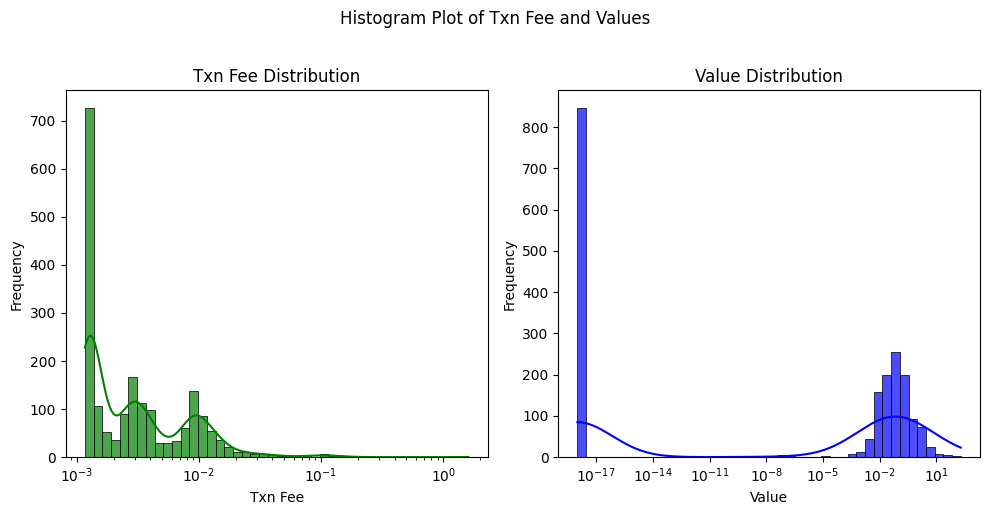

In [6]:
plt.figure(figsize=(10, 5))
plt.suptitle('Histogram Plot of Txn Fee and Values', y=1.02) 

plt.subplot(1, 2, 1)
plt.xscale('log')
sns.histplot(df['Txn Fee'], bins=int(math.sqrt(len(df['Txn Fee']))), color='g', kde=True, alpha=0.7)
plt.title('Txn Fee Distribution')
plt.xlabel('Txn Fee')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
# plt.xlim(0,df['Value'].mean()) 
plt.xscale('log')
sns.histplot(df['Value'], bins=int(math.sqrt(len(df['Value']))), color='b', kde=True, alpha=0.7)
plt.title('Value Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


As it currently stands from the subplots, the majority of transactions fall within the value range of 0 to 0.05. The reason for this is that most of the transactions involve coin swaps. In other words, individuals involved in the transactions are simply exchanging one coin for another within the same network, or in some cases, using coins to unlock transactions (especially when gaining "Meme Coins"). It is important to note, however, that this does not justify the high frequency of Txn Fee at $10^{-17}$ or lower, as some of the transactions with zero value have significantly larger Txn fees.


The following plot we have is based on the data after we removed the rows with very small values. This was done in order to exclude the coin-swap transactions and coin submittions. The x-axis of the distribution of transaction fees is set to logarithmic scale

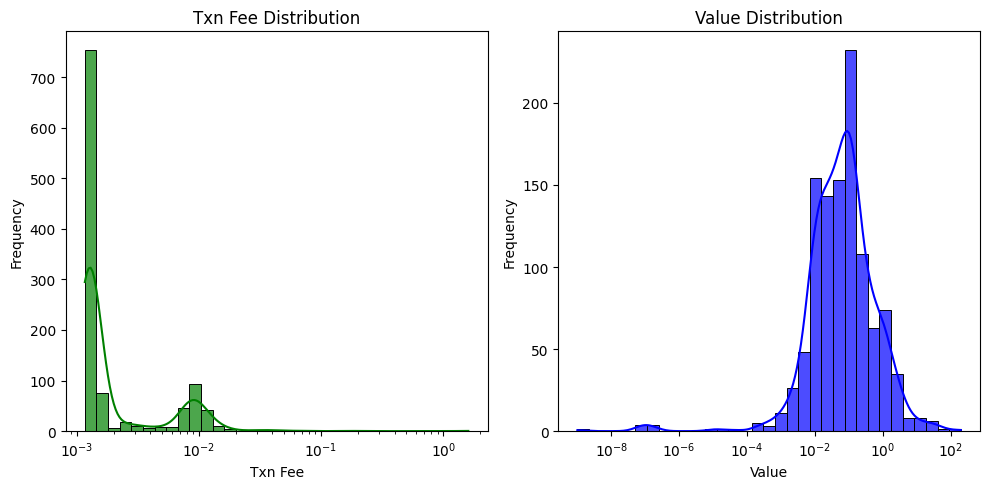

In [7]:
non_zero_df = df[df['Value'] > 10**-15]
non_zero_df.to_csv("non-zero_output.csv")

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.xscale('log')
sns.histplot(non_zero_df['Txn Fee'], bins=int(math.sqrt(len(non_zero_df['Txn Fee']))), color='g', kde=True, alpha=0.7)
plt.title('Txn Fee Distribution')
plt.xlabel('Txn Fee')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.xscale('log')
sns.histplot(non_zero_df['Value'], bins=int(math.sqrt(len(non_zero_df['Value']))), color='b', kde=True, alpha=0.7)
plt.title('Value Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Now, let's try to fit a normal or poisson distribution to the  data. Note that we can't show the bins with log scaling as it would be misleading. Just to show you how, this is the standard normal distribution plotted with x-axis set to logarithmic scale:

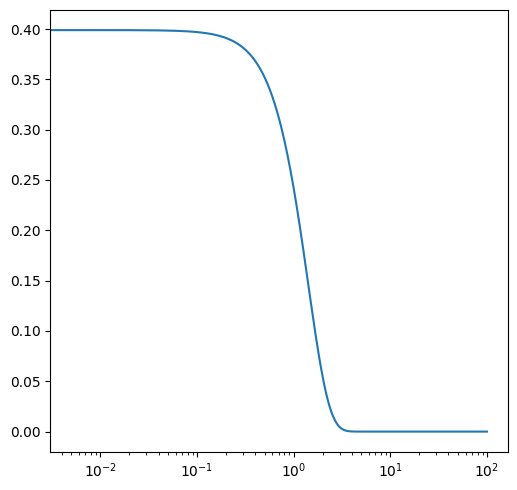

In [8]:
x = np.linspace(0, 100, 20000)
y = norm.pdf(x, 0, 1)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.xscale('log')
plt.plot(x, y)

plt.tight_layout()
plt.show()

We recalculated and reprinted the mean and std of the columns 'Value' and 'Txn Fee', as we've applied a filter on the data. the scaling factor is used to show better fitness with the data. 
## Why This Scaling Factor ##

Txn Fee Mu is 0.004831320522456462
Txn Fee Std is 0.0490813004810927
175.273707107
Value Mu is 0.787261255046746
Value Std is 6.805203313016304
175.273707107


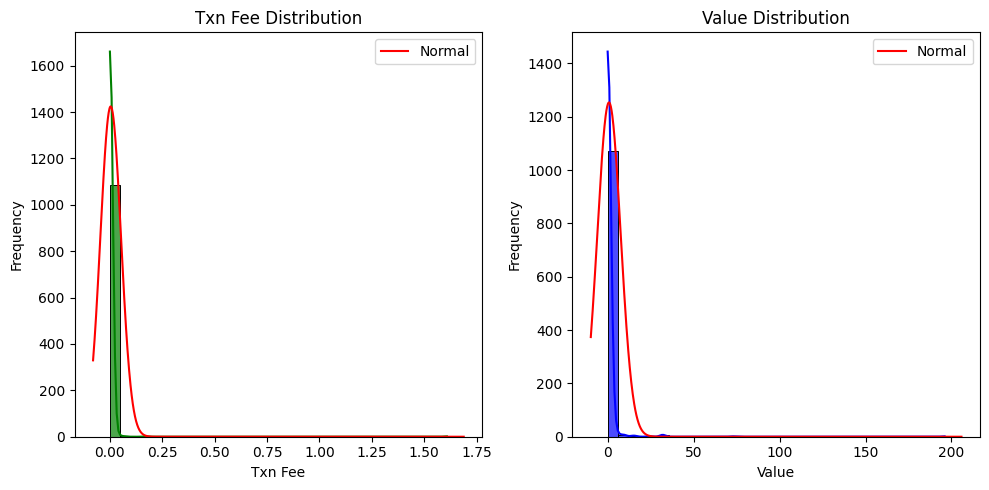

In [14]:
df = non_zero_df
plt.figure(figsize=(10, 5))

# df[['Value', 'Txn Fee']].to_csv("test.csv", index = False)

plt.subplot(1, 2, 1)
# plt.xscale('log')
sns.histplot(df['Txn Fee'], bins=int(math.sqrt(len(non_zero_df['Txn Fee']))), color='g', kde=True, alpha=0.7)
mu_txn_fee = df['Txn Fee'].mean()
sigma_txn_fee = df['Txn Fee'].std()
print(f"Txn Fee Mu is {mu_txn_fee}")
print(f"Txn Fee Std is {sigma_txn_fee}")
scaling_factor = len(df['Txn Fee']) * np.diff(np.histogram(df['Txn Fee'])[1])[0]
print(scaling_factor)

xmin, xmax = plt.xlim()
txn_fee_x = np.linspace(xmin, xmax, 1000)
txn_fee_norm = norm.pdf(txn_fee_x, mu_txn_fee, sigma_txn_fee) * scaling_factor

plt.plot(txn_fee_x, txn_fee_norm, color='r', label='Normal')

plt.title('Txn Fee Distribution')
plt.xlabel('Txn Fee')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
# plt.xscale('log')
sns.histplot(df['Value'], bins=int(math.sqrt(len(non_zero_df['Value']))), color='b', kde=True, alpha=0.7)
mu_value = df['Value'].mean()
sigma_value = df['Value'].std()
print(f"Value Mu is {mu_value}")
print(f"Value Std is {sigma_value}")
print(scaling_factor)
scaling_factor = np.diff(np.histogram(df['Value'])[1])[0] * len(df['Value'])

xmin, xmax = plt.xlim()
value_x = np.linspace(xmin, xmax, 1000)
value_norm = norm.pdf(value_x, mu_value, sigma_value) * scaling_factor

plt.plot(value_x, value_norm, color='r', label='Normal')

plt.title('Value Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

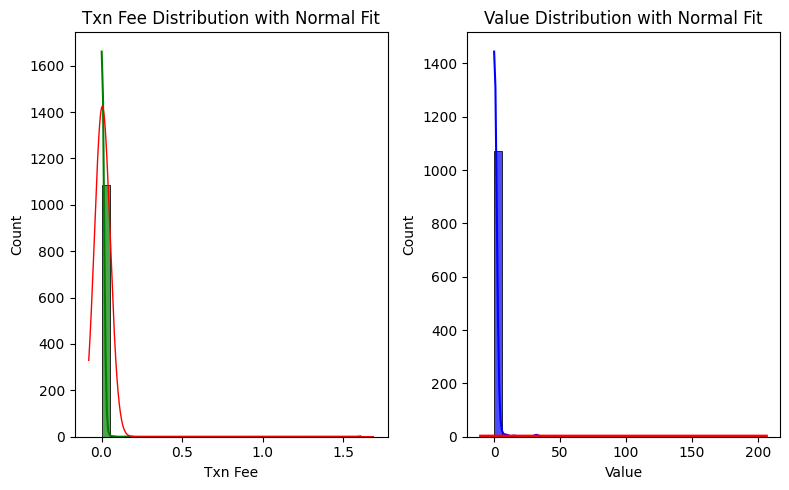

In [10]:
plt.figure(figsize=(8, 5))

plt.subplot(1, 2, 1)
# plt.xscale('log')
sns.histplot(df['Txn Fee'], bins=int(math.sqrt(len(df['Txn Fee']))), kde=True, color='g', alpha=0.7)
mu, std = df['Txn Fee'].mean(), df['Txn Fee'].std()
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 1000)
p = norm.pdf(x, mu, std)
scaling_factor = len(df['Txn Fee']) * np.diff(np.histogram(df['Txn Fee'])[1])[0]
plt.plot(x, p * scaling_factor, 'r', linewidth=1)
plt.title('Txn Fee Distribution with Normal Fit')
plt.xlabel('Txn Fee')

plt.subplot(1, 2, 2)
sns.histplot(df['Value'], bins=int(math.sqrt(len(df['Value']))), kde=True, color='b', alpha=0.7)
mu, std = df['Value'].mean(), df['Value'].std()
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)

# df['Value'].dropna(inplace=True)
# df['Value'] = df['Value'].replace([np.inf, -np.inf], np.nan).dropna() 

# scaling_factor = len(df['Value']) * np.diff(np.histogram(df['Value'])[1])[0]
plt.plot(x, p, 'r', linewidth=3)
# plt.xscale('log')

plt.title('Value Distribution with Normal Fit')
plt.xlabel('Value')
plt.ylim(bottom=0)

plt.tight_layout()
plt.show()

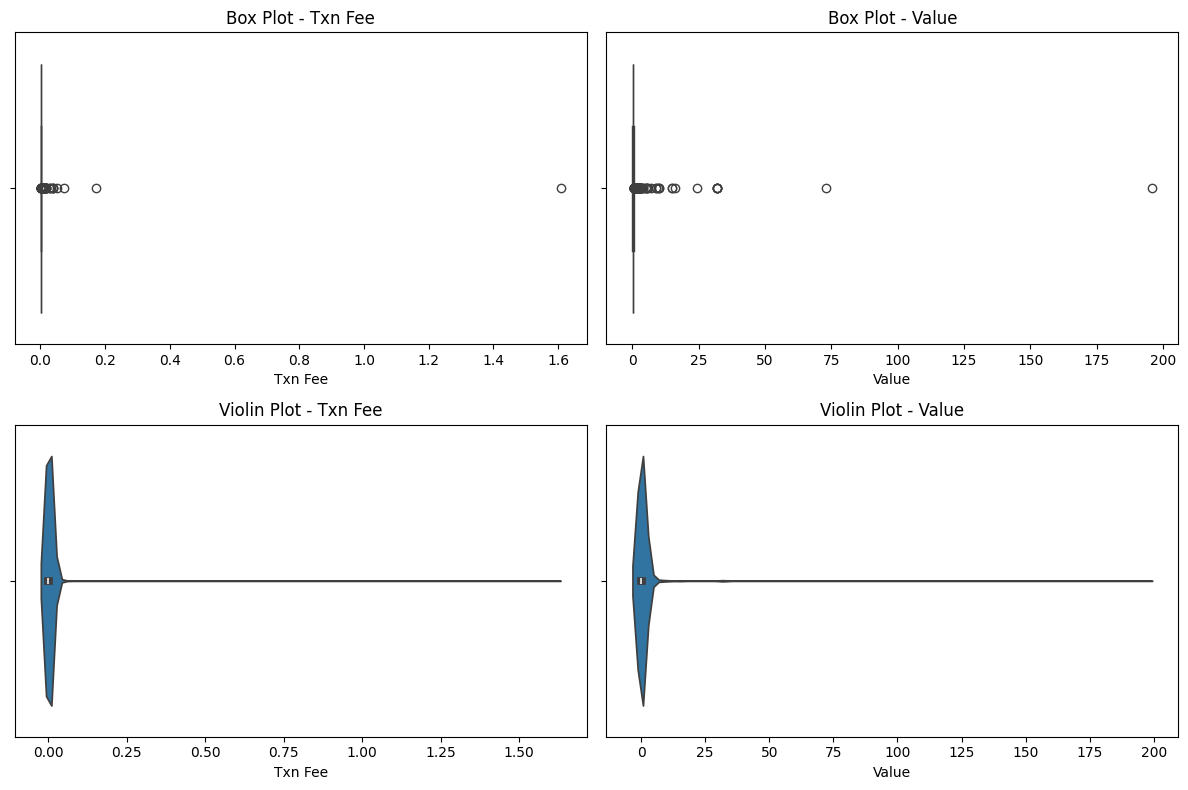

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

sns.boxplot(x=df['Txn Fee'], ax=axes[0, 0])
axes[0, 0].set_title('Box Plot - Txn Fee')

sns.violinplot(x=df['Txn Fee'], ax=axes[1,0])
axes[1,0].set_title('Violin Plot - Txn Fee')

sns.boxplot(x=df['Value'], ax=axes[0, 1])
axes[0, 1].set_title('Box Plot - Value')

sns.violinplot(x=df['Value'], ax=axes[1, 1])
axes[1, 1].set_title('Violin Plot - Value')

plt.tight_layout()
plt.show()
